## Read and Write rasters to bring model information to/from GIS GUIs

In [101]:
import sys
sys.path.insert(0, 'D:/ATLData/Documents/GitHub/flopy')
sys.path.insert(0, '/Users/aleaf/Documents/GitHub/flopy3')
from rasterio import Affine
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import flopy
from GISio import arc_ascii
fm = flopy.modflow

%matplotlib inline

#### load model using flopy

In [55]:
m = fm.Modflow.load('haskell.nam', model_ws='modflow', version='mfnwt')

#### this model already has spatial reference information that was populated from the `nam` file

In [102]:
m.sr

xul:272300; yul:5090572; rotation:0; proj4_str:+proj=utm +zone=16 +ellps=GRS80 +datum=NAD83 +units=m +no_defs; units:meters; lenuni:2; length_multiplier:0.3048

### Write a Geotiff using `rasterio`

#### create an `Affine` object to position grid in space

In [56]:
dxdy_m = m.sr.delc[0] * m.sr.length_multiplier

trans = Affine(dxdy_m, 0., m.sr.xul, 0., -dxdy_m, m.sr.yul)

#### set up other raster properties and write a numpy array to Band 1

In [97]:
properties = {'count': 1, # number of bands
            'crs': '+init=epsg:26916', # coordinate system
            'transform': trans,
            'width': m.ncol,
            'height': m.nrow,
            'driver': 'GTiff',
            'dtype': np.float32,
            'nodata': 0
             }

with rasterio.open('rasters/modeltop.tif', 'w', **properties) as dst:
    dst.write(m.dis.top.array, 1)

#### read the raster back in to check that it was written properly

In [99]:
with rasterio.open('rasters/modeltop.tif') as src:
    mt = src.read(1) # read band 1 to numpy array

In [100]:
mt

array([[ 1607.18005371,  1605.69995117,  1605.76000977, ...,
         1547.86999512,  1548.7800293 ,  1548.7800293 ],
       [ 1606.68994141,  1605.51000977,  1605.9699707 , ...,
         1547.86999512,  1548.7800293 ,  1548.7800293 ],
       [ 1606.13000488,  1605.52001953,  1605.75      , ...,
         1544.20996094,  1545.85998535,  1545.85998535],
       ..., 
       [ 1570.06005859,  1571.2199707 ,  1571.2199707 , ...,
         1567.11999512,  1567.25      ,  1567.31005859],
       [ 1571.86999512,  1571.86999512,  1571.86999512, ...,
         1567.36999512,  1567.23999023,  1567.32995605],
       [ 1571.86999512,  1571.86999512,  1571.86999512, ...,
         1567.36999512,  1567.26000977,  1567.30004883]], dtype=float32)

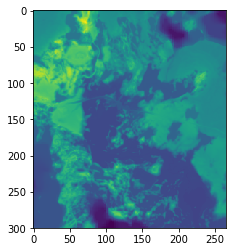

In [60]:
plt.imshow(mt)

### Write an Arc Ascii grid file

In [105]:
arc_ascii(mt, 'rasters/modeltop.asc', xll=m.sr.xll, yll=m.sr.yll, cellsize=dxdy_m, fmt='%.2f')

wrote rasters/modeltop.asc


#### read an Arc Ascii grid to a numpy array

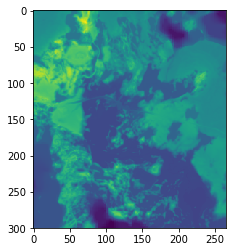

In [107]:
mt = np.loadtxt('rasters/modeltop.asc', skiprows=6 # skip the header
               )
plt.imshow(mt)

### Make a cross section of the model layering

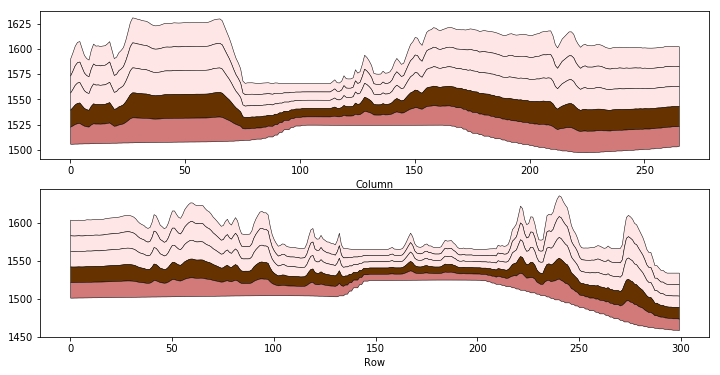

In [108]:
top = m.dis.top.array
botm = m.dis.botm.array

# set colors (see https://www.w3schools.com/colors/colors_picker.asp)
unit_colors = {'upper coarse': (255, 230, 230),
          'wildcat': (102, 51, 0),
          'lower coarse': (210, 121, 121)}

colors = [unit_colors['upper coarse'],
          unit_colors['upper coarse'],
          unit_colors['upper coarse'],
          unit_colors['wildcat'],
          unit_colors['lower coarse']]
colors = list(map(tuple, np.array(colors)/255))

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# West-East cross section
axes[0].fill_between(range(m.ncol), top[150, :], botm[0, 150, :], 
                     facecolor=colors[0], edgecolor='k', lw=0.5)
for i in range(m.nlay-1):
    axes[0].fill_between(range(m.ncol), botm[i, 150, :], botm[i+1, 150, :], 
                         facecolor=colors[i+1], edgecolor='k', lw=0.5)
    axes[0].set_xlabel('Column')

# North-South cross section
axes[1].fill_between(range(m.nrow), top[:, 105], botm[0, :, 105], 
                     facecolor=colors[0], edgecolor='k', lw=0.5)
for i in range(m.nlay-1):
    axes[1].fill_between(range(m.nrow), botm[i, :, 105], botm[i+1, :, 105], 
                         facecolor=colors[i+1], edgecolor='k', lw=0.5)
    axes[1].set_xlabel('Row')